In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import time
#A continuación se importan laas librerias necesarias para el entrenamiento de la red 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from keras.optimizers import SGD, Adam


Using TensorFlow backend.


(210108,)


Text(0.5, 1.0, 'Datos reales')

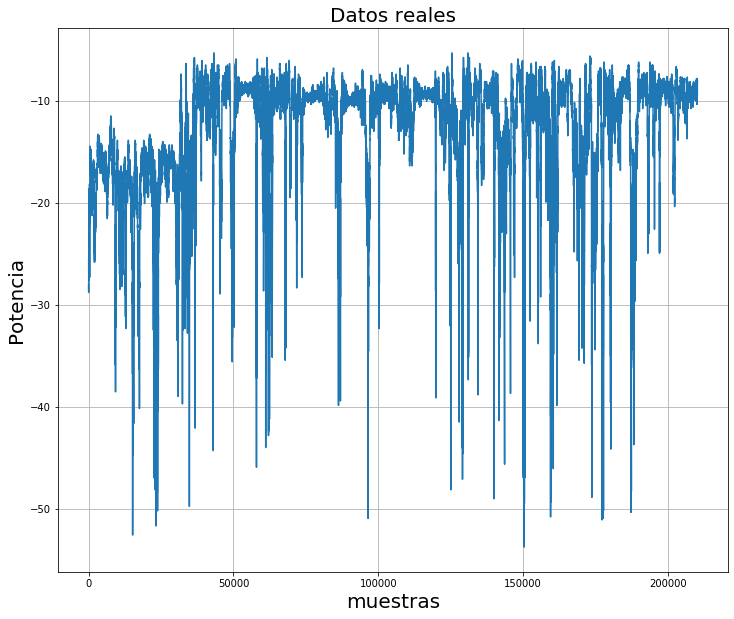

In [3]:
dataframe = pd.read_csv('/content/drive/My Drive/Mediciones en csv/HTLOS CSV/potencia 2000-01-03 21_3A11_3A34 Antenna Horn Time 300[s] SwitchingBy 0 Horn 0 Omni 0 ING-AU_033.csv', header=None )
#llevar al dataframe a un arreglo de valores
dataset = dataframe.values
#dataset solo para la funcion senoidal
POT = dataset[0:len(dataset),1]
#POT = dataset
print(POT.shape)
plt.figure(figsize=[12,10])
plt.grid()
plt.plot(POT)
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.title("Datos reales", fontsize = 20)

# Nueva sección

In [4]:
#llevo la funcion a un arreglo de [lARGO DEL ARREGLO ,1] PARA ESCALAR LOS DATOS y que la red aprenda de mejor forma
POT2=POT.reshape(len(POT),1)
print(POT2.shape)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
POT2 = scaler.fit_transform(POT2)

(210108, 1)


In [5]:
# divido la funcion y1 en arreglos para entrenar y probar la red
train_size = int(len(POT2) * 0.8)
test_size = len(POT2) - train_size
train, test = POT2[0:train_size,:], POT2[train_size:len(POT2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

168086 42022
(168086, 1)
(42022, 1)


In [0]:
# convertir un arreglo de valores en una matrix
def create_dataset(POT2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(POT2)-look_back-1):
        a = POT2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(POT2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# reshape dentro X=t and Y=t+1
look_back = 128
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
#print(trainX[0])
#print(trainY[0])
#print(trainX[1])
#print(trainY[1])
#print(trainX[2])
#print(trainY[3])

(167957, 128)
(41893, 128)
(167957,)
(41893,)


In [8]:
# reshape a la entrada [samples, time steps, features] que es necesario para la red lstm
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(167957, 1, 128)
(41893, 1, 128)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

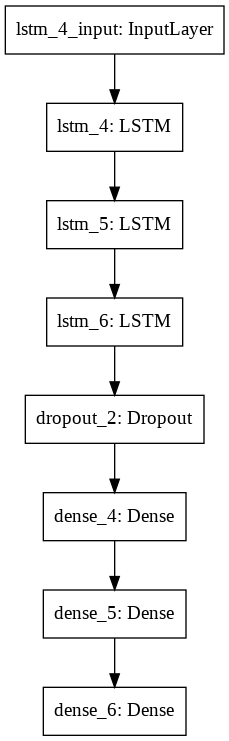

In [14]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(256, activation = 'relu',return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mape','mse','mae'])
model.summary()
keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
filepath="Checkpoint_mejores_pesos_señal_htlos_S1_lstm_stacked.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_percentage_error', verbose=1, save_best_only=True, mode='min')
# simple early stopping
es = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=5)

In [16]:
batch_size= 32 
epochs= 30
start = time.time()
History_htlos1_lstm_stacked = model.fit(trainX, trainY,batch_size=batch_size, epochs= epochs, callbacks=[es, checkpoint] , validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 151161 samples, validate on 16796 samples
Epoch 1/30





151161/151161 [==============================] - 99s 658us/step - loss: 0.0018 - mean_absolute_percentage_error: 3281.3736 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0213 - val_loss: 7.4058e-04 - val_mean_absolute_percentage_error: 2.9306 - val_mean_squared_error: 7.4058e-04 - val_mean_absolute_error: 0.0232

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 2.93056, saving model to Checkpoint_mejores_pesos_señal_htlos_S1_lstm_stacked.hdf5
Epoch 2/30
151161/151161 [==============================] - 93s 615us/step - loss: 3.7377e-04 - mean_absolute_percentage_error: 2061.4980 - mean_squared_error: 3.7377e-04 - mean_absolute_error: 0.0125 - val_loss: 5.9419e-04 - val_mean_absolute_percentage_error: 2.5862 - val_mean_squared_error: 5.9419e-04 - val_mean_absolute_error: 0.0206

Epoch 00002: val_mean

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_htlos_señal1_lstm_stacked.json", "w") as json_file:
    json_file.write(model_json)


In [0]:
import pickle

pickle_out = open("History_htlos1_lstm_stacked.pickle","wb")
pickle.dump(History_htlos1_lstm_stacked, pickle_out)
pickle_out.close()

In [0]:
import pickle 

pickle_in = open("History_htlos1_lstm_stacked.pickle","rb")
History_saved = pickle.load(pickle_in)


In [0]:
History = History_saved

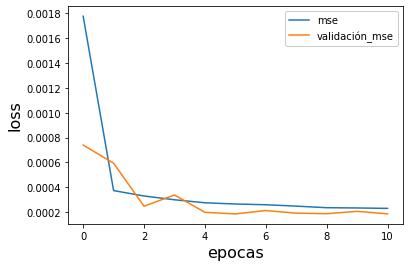

In [21]:
# plot metrics
#plt.figure(figsize=[8,8])
plt.plot(History.history['mean_squared_error'], label='mse')
plt.plot(History.history['val_mean_squared_error'], label= 'validación_mse')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

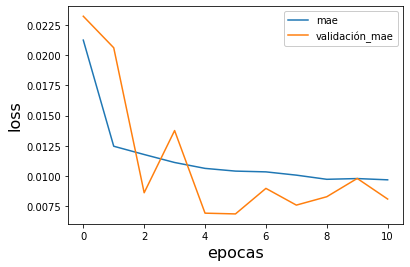

In [22]:
plt.plot(History.history['mean_absolute_error'], label='mae')
plt.plot(History.history['val_mean_absolute_error'], label= 'validación_mae')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [0]:
#History.history['mean_absolute_percentage_error']

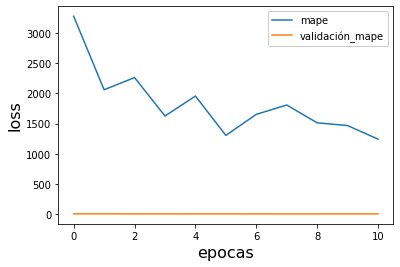

In [24]:
plt.plot(History.history['mean_absolute_percentage_error'], label= 'mape')
plt.plot(History.history['val_mean_absolute_percentage_error'], label= 'validación_mape')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [25]:
# predicciones de los valores de prueba
prediccion_test = model.predict(testX)
prediccion_test = scaler.inverse_transform(prediccion_test)
#actuals = test_y
valor_real_test = scaler.inverse_transform([testY])
valor_real_test= valor_real_test.reshape(len(prediccion_test),1)
#prediccion de los valores de entrenamiento
aprendido=model.predict(trainX)
aprendido_train=scaler.inverse_transform(aprendido)
reales_train=scaler.inverse_transform([trainY])
reales_train=scaler.inverse_transform([trainY])
reales_train=reales_train.reshape(len(aprendido),1)
###################################################
mse_aprendido=mean_squared_error(reales_train,aprendido_train)
mse_test=mean_squared_error(valor_real_test,prediccion_test)
print('Train Mean square Error:', mse_aprendido)
print('Test Mean square Error:', mse_test)
#######################################################
rmse_train=math.sqrt(mse_aprendido)
rmse_test=math.sqrt(mse_test)
print('Train Root Mean Squared Error:', rmse_train)
print('Test Root Mean Squared Error:', rmse_test)


Train Mean square Error: 0.39544188886222736
Test Mean square Error: 0.38772912205132476
Train Root Mean Squared Error: 0.6288417041372394
Test Root Mean Squared Error: 0.6226789879635611


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
#mape train
mean_absolute_percentage_error(reales_train,aprendido_train)

2.885652174727813

In [28]:
#mape test
mean_absolute_percentage_error(valor_real_test,prediccion_test)

2.8517861521425547

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [30]:
smape(reales_train,aprendido_train)

2.9346992762934376

In [31]:
smape(valor_real_test,prediccion_test)

2.9013222473560494

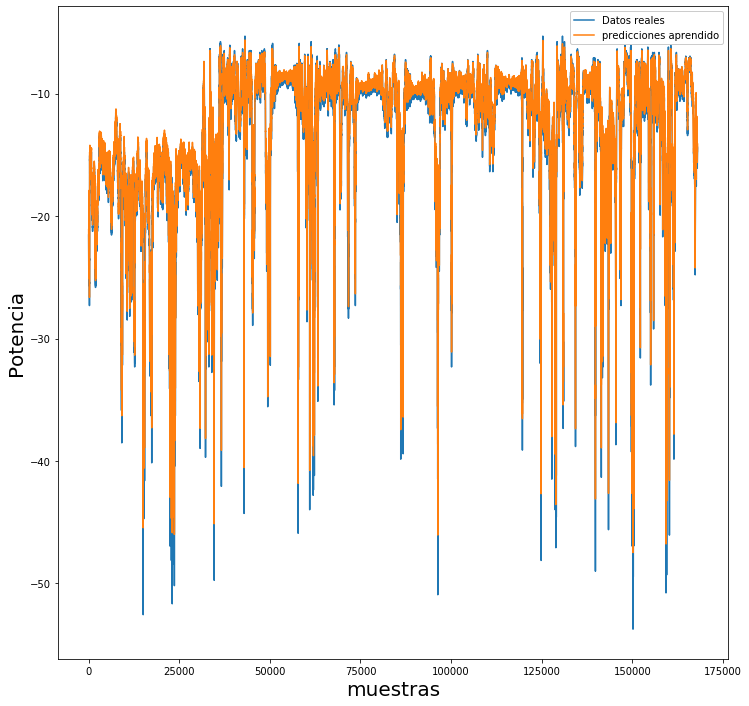

In [32]:
# plot entrenamiento
plt.figure(figsize=[12,12])
plt.plot(reales_train, label='Datos reales')
plt.plot(aprendido_train, label= 'predicciones aprendido')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

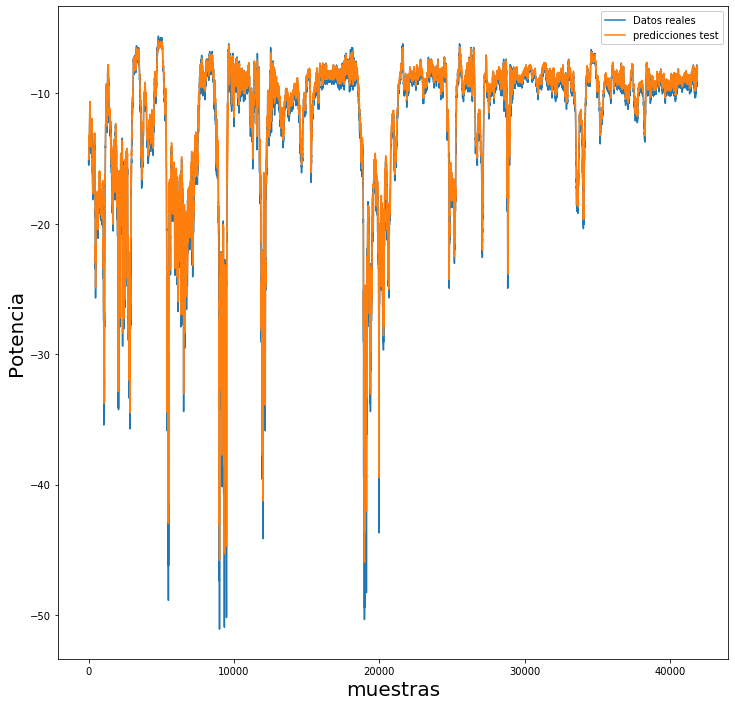

In [33]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test, label='Datos reales')
plt.plot(prediccion_test , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

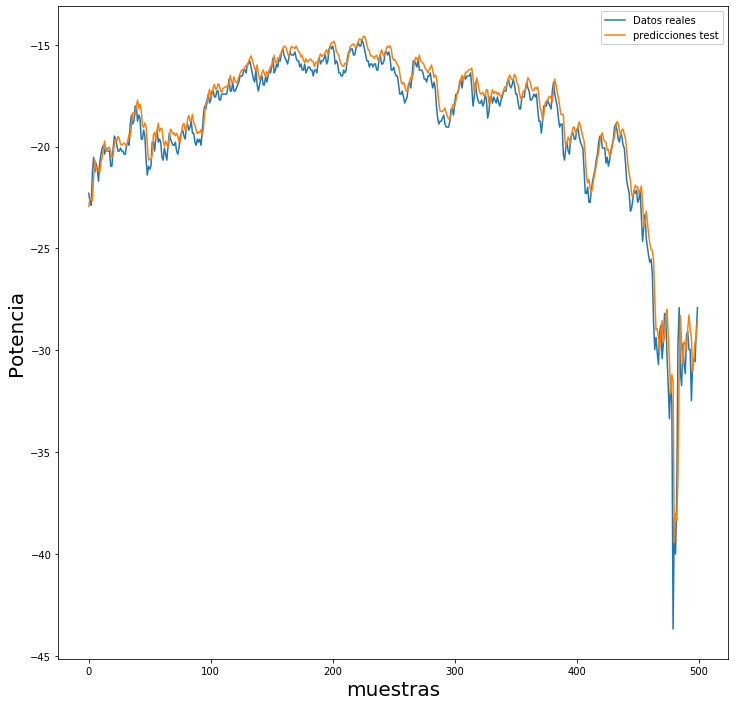

In [44]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test[19500:20000], label='Datos reales')
plt.plot(prediccion_test[19500:20000] , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

In [35]:
acc = abs(prediccion_test-valor_real_test)
porc_error = (acc / abs(valor_real_test)) * 100
mostrar = valor_real_test, prediccion_test, acc, porc_error
Tabla_arr = np.array(mostrar)
Tabla = np.transpose(Tabla_arr)
Tabla=Tabla.reshape(len(acc), -1)
Tabla_df = pd.DataFrame(Tabla, columns=['Datos predichos','Datos reales','Error','Error porcentual'])
Tabla_df

,Datos predichos,Datos reales,Error,Error porcentual
0,-15.20,-14.760635,0.439365,2.890557
1,-15.50,-14.800694,0.699306,4.511649
2,-15.35,-14.990769,0.359231,2.340265
3,-15.06,-15.000331,0.059669,0.396209
4,-15.35,-14.812172,0.537828,3.503766
...,...,...,...,...
41888,-8.41,-8.364588,0.045412,0.539979
41889,-8.27,-8.371719,0.101719,1.229980
41890,-8.12,-8.304693,0.184693,2.274547
41891,-8.12,-8.182351,0.062351,0.767871


In [0]:
import seaborn as sns

In [0]:
aprendido_red=aprendido_train[:,0]
rial=reales_train[:,0]
testing=valor_real_test[:,0]
prediccion=prediccion_test[:,0]

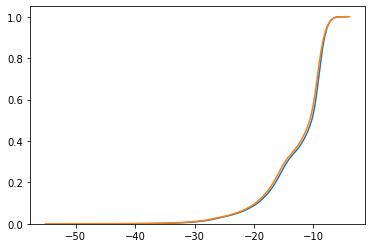

In [38]:
sns.kdeplot(aprendido_red, cumulative=True)
sns.kdeplot(rial, cumulative=True)

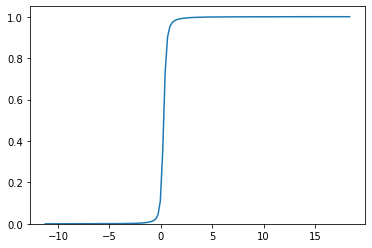

In [39]:
err_apre=aprendido_train-reales_train
err_2=err_apre[:,0]
sns.kdeplot(err_2, cumulative=True)

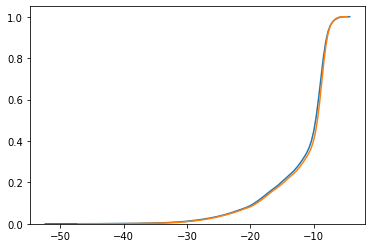

In [40]:
sns.kdeplot(testing, cumulative=True)
sns.kdeplot(prediccion, cumulative=True)

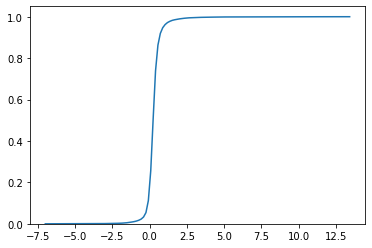

In [41]:
err=prediccion_test-valor_real_test
err_1=err[:,0]
sns.kdeplot(err_1, cumulative=True)

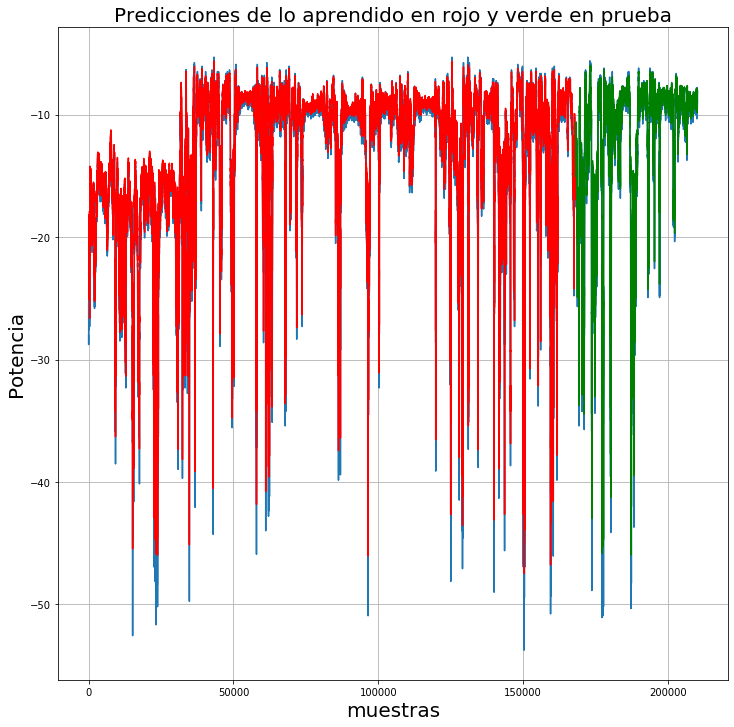

In [42]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(POT2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(aprendido_train)+look_back, :] = aprendido_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(POT2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(aprendido_train)+(look_back*2)+1:len(POT2)-1, :] = prediccion_test
# plot baseline and predictions
plt.figure(figsize=[12,12])
plt.plot((POT))
plt.plot(trainPredictPlot, color="red", )
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.plot(testPredictPlot, color="green")
plt.title("Predicciones de lo aprendido en rojo y verde en prueba", fontsize = 20)
plt.grid()
plt.show()

In [0]:
adqw=trainPredictPlot+testPredictPlot